Hi Sean,

    This looks good! There are some things we need to fix up, but it should be quick from this point.
    
    Joy
    
    
1. Quadruples
    * some of the quadruples are somewhat funny looking
        * we want everything to have form x = y op z
        * this should have a quadruple [x,y,op,z]
        * for the next part, it will be important to have these be consistent
        * your quadruples temp = x = 1 are not of the correct form
2. Do-while
    * there is an issue with the labeling here
    * The unconditional jump should goto the do label
3. For
    * the labeling here is incorrect
    * example

source:
```c
for(i=1;i<2;i=i+1;){
    x = x + 1;
}
```

intermediate code
```
i = 1
for_label :
if i >= 2 goto out_label
x = x + 1
i = i + 1
goto for_label
out_label :
```

4. If-Else
    * The if-else construct you are using is incorrect.
        * specifically, the code will never get to the false section
    * the following construct is better (there are many, this is just one)
        * the difference is that I flipped the inequality and then jump to the false label
        * if the original check (x>=1) is true, the first jump does *not* happen and the true code runs
        * if the original check is false, the flipped check is true and we jump to the false code

source:
```c
if (x >= 1){
    x += 2;
}
else{
    x = 1;
}
```

intermediate code:
```
if x < 1, goto false_label
x += 2
goto out_label
false_label
x = 1
out_label
```

5. Arrays
    * I think there may be an issue with your translator regarding arrays
        * my guess is that the issue is in factor as the example of the array on the right hand side failed
    * we need to make the array on the left hand side for assignments work with the intermediate code
    * we need to make the array on the right hand side for assignments work with the intermediate code

In [38]:
%run UpdatedTranslator_Murray.ipynb

<mark>___________________________________________________________________________________________________________________________________</mark>

In [31]:
def int_code_gen(T,v,vv):
    """traverses the abstract syntax tree T and produces intermediate code for expressions"""
    flip = {'<': '>=', '>': '<=', '==': '==', '<=': '>', '>=': '<'} #flip relop signs
    #-----------------------------------------------------------------------------------------------
    def label(s):
        """returns a string with a number attached for uniqueness"""
        nonlocal count
        
        count += 1
        return s + str(count)
    
    #-----------------------------------------------------------------------------------------------
    def traverse(T,p):
        """traverses the tree producing intermediate code"""
        
        #-------------------------------PRE-ORDER VISIT ACTION------------------------------------------
        if p.element() == "asID":
                int_code.append(["assn"])
        if p.element() == 'while':
            label_name = label("while")
            out_name = label("outw")
            int_code.append(["while", label_name, out_name])
            A.append(["while", label_name, out_name])
            if v:print(label_name, ':')
        if p.element() == "if":
            label_name = label("if")
            out_name = ("out_if")
            int_code.append(["if", label_name, out_name])
            A.append(["if", label_name, out_name])
            if v:print(label_name, ":")
        elif p.element() == "else":
            label_name = label("else")
            out_name = ("out_else")
            int_code.append(["else", label_name, out_name])
            A.append(["else", label_name, out_name])
            if v:print(label_name, ":")
        if p.element() == "for":
            label_name = label("for")
            out_name = ("out_for")
            int_code.append(["for", label_name, out_name])
            A.append(["for", label_name, out_name])
            if v:print(label_name, ":")
        if p.element() == "do":
            label_name = label("do")
            out_name = ("out_do")
            int_code.append(["do", label_name, out_name])
            A.append(["do", label_name, out_name])
            if v:print(label_name, ':')
        #-------------------------------PRE-ORDER VISIT ACTION------------------------------------------
        
        
        
        for pos in T.children(p):       # Recursive call to children of p
            
            #--------------------------------IN-ORDER VISIT ACTION------------------------------------------
            if pos.element() in ['expr','e']:
                record = A.pop()                                                 # pop current activation record
                int_code.append(["label",record[2],None,None])                   # append quadruple to output
                if v: print(record[2],":")                                       #---------------------------print output
            #--------------------------------IN-ORDER VISIT ACTION------------------------------------------
    
            traverse(T,pos)
                
            if p.element() == "while":
                if pos.element() in ['<', '>', '<=', '>=', '==']:
                    record = A.pop()
                    out_wlabel = record[-1]
                    
                    wrelop = S.pop() # pop the three relop tokens
                    wright = S.pop()
                    wleft = S.pop()
                    if v: print("if", wleft, flip[str(wrelop)], wright, "goto", out_wlabel)
                    if v: print("goto", label_name)
                    int_code.append(["label", out_wlabel, None, None])
                    traverse(T, pos)
            if p.element() == "if":
                if pos.element() in ['<', '>', '<=', '>=', '==']:
                    record = A.pop()
                    out_iflabel = record[-1]
                    
                    ifrelop = S.pop()
                    ifright = S.pop()
                    ifleft = S.pop()
                    if v: print("if", ifleft, flip[str(ifrelop)], ifright, "goto", out_iflabel)
                    if v: print("goto", label_name)
                    int_code.append(["label", out_iflabel, None, None])
                    traverse(T, pos)
            if p.element() == "else":
                if pos.element() in ['<', '>', '<=', '>=', '==']:
                    record = A.pop()
                    out_elselabel = record[-1]
                    
                    if v: print("goto", label_name)
                    int_code.append(["label", out_elselabel, None, None])
                    traverse(T, pos)
            if p.element() == "for":
                if pos.element() in ['<', '>', '<=', '>=', '==']:
                    record = A.pop()
                    out_forlabel = record[-1]
                    
                    forrelop = S.pop()
                    forright = S.pop()
                    forleft = S.pop()
                    if v: print("for", forleft, flip[str(forrelop)], forright, "goto", out_forlabel)
                    if v: print("goto", label_name)
                    int_code.append(["label", out_forlabel, None, None])
                    traverse(T, pos)
                    
                
        #------------------------------POST-ORDER VISIT ACTION------------------------------------------
        if p.element() in ['+','-','*','/', '=']: # check for operators
            right = S.pop()                                                  # pop (most recent) operand
            left = S.pop()                                                   # pop (older) operand
            temp_name = label("temp")                                        # generate temporary label
            
            int_code.append([temp_name,str(left),p.element(),str(right)])    # save Quadruple to output
            if v: print(temp_name,"=",str(left),p.element(),str(right))      #---------------------------print output
            
            S.append(temp_name)                                              # push temporary label to stack
        #Post order -- end labels
        elif p.element() == 'for':
            if v: print(out_forlabel, ":")
        elif p.element() == 'while':
            if v: print(out_wlabel, ":")
        elif p.element() == 'if':
            if v: print(out_iflabel, ":")
            if p.element() == 'else':
                if v: print(out_elselabel, ":")
        elif p.element() == "int":
            temp_name = label("dec")
            var_name = S.pop() #ID
            var2_name = S.pop() #var name
                
            if str(var2_name).isnumeric():
                var3_name = S.pop()
                array_size = var2_name
                int_code.append([temp_name, var3_name, array_size, None])
                if vv: print(temp_name,"=",var3_name, "size: ", array_size)
            else:
                int_code.append([temp_name, var2_name, None, None])
                if vv: print(temp_name,"=",var2_name)
        elif p.element() in ['expr','e']:
            pass                                                             # do nothing for these nodes (at this time)
        else:
            S.append(p.element())                                            # push non-operators nodes on the stack
        #------------------------------POST-ORDER VISIT ACTION----------------------------------------------
        
    
    
    
    int_code = []
    count = 0
    S = []                       # stack for operands/results
    A = []                       # stack for activiation records
    
    if v: print("-"*100)
    traverse(T,T.root())       # call the recursive code above
    if v: print("-"*100)
    
    return int_code

In [32]:
def intermediate_code_generator(source,v=True,vv=True):
    """wrapper/driver for intermediate code generator"""
    
    T = translate(source)           # translate the source to an AST
    
    if vv: printTree(T,1,2000,18)   # print the AST (if very verbose)
    
    int_code = int_code_gen(T,v,vv)
    
    if v: print("\n\nQuadruples")
    return int_code

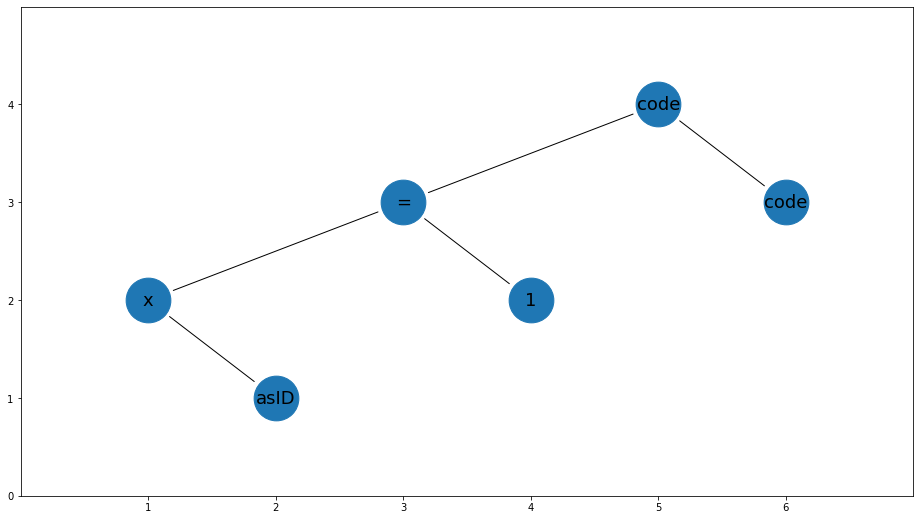

----------------------------------------------------------------------------------------------------
temp1 = x = 1
----------------------------------------------------------------------------------------------------


Quadruples


[['assn'], ['temp1', 'x', '=', '1']]

In [33]:
intermediate_code_generator("""x = 1; """,1,1)

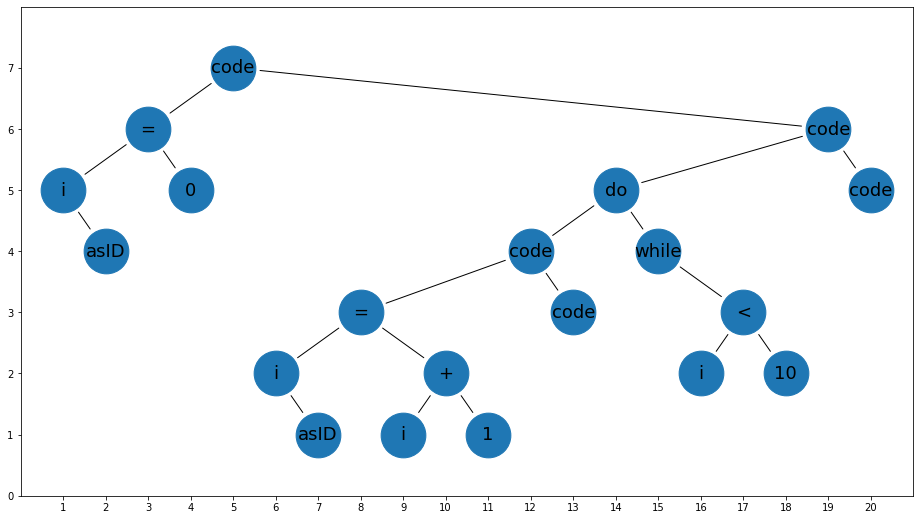

----------------------------------------------------------------------------------------------------
temp1 = i = 0
do2 :
temp3 = i + 1
temp4 = i = temp3
while5 :
if i >= 10 goto outw6
goto while5
outw6 :
----------------------------------------------------------------------------------------------------


Quadruples


[['assn'],
 ['temp1', 'i', '=', '0'],
 ['do', 'do2', 'out_do'],
 ['assn'],
 ['temp3', 'i', '+', '1'],
 ['temp4', 'i', '=', 'temp3'],
 ['while', 'while5', 'outw6'],
 ['label', 'outw6', None, None]]

In [34]:
intermediate_code_generator("""
i = 0;
do {
i = i + 1;
} while (i < 10)
""",1,1)

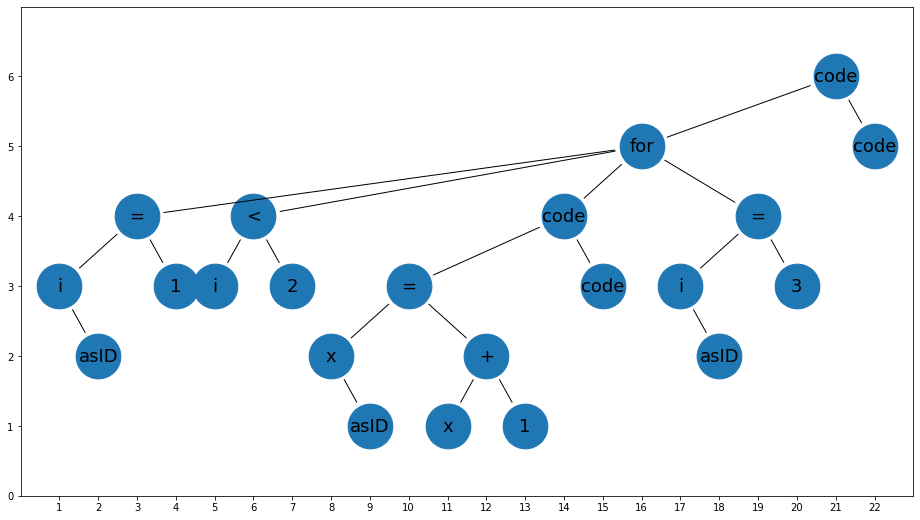

----------------------------------------------------------------------------------------------------
for1 :
temp2 = i = 1
for i >= 2 goto out_for
goto for1
temp3 = x + 1
temp4 = x = temp3
temp5 = i = 3
out_for :
----------------------------------------------------------------------------------------------------


Quadruples


[['for', 'for1', 'out_for'],
 ['assn'],
 ['temp2', 'i', '=', '1'],
 ['label', 'out_for', None, None],
 ['assn'],
 ['temp3', 'x', '+', '1'],
 ['temp4', 'x', '=', 'temp3'],
 ['assn'],
 ['temp5', 'i', '=', '3']]

In [35]:
intermediate_code_generator("""
for(i=1;i<2;i=3;){
    x = x + 1;
}
""",1,1)

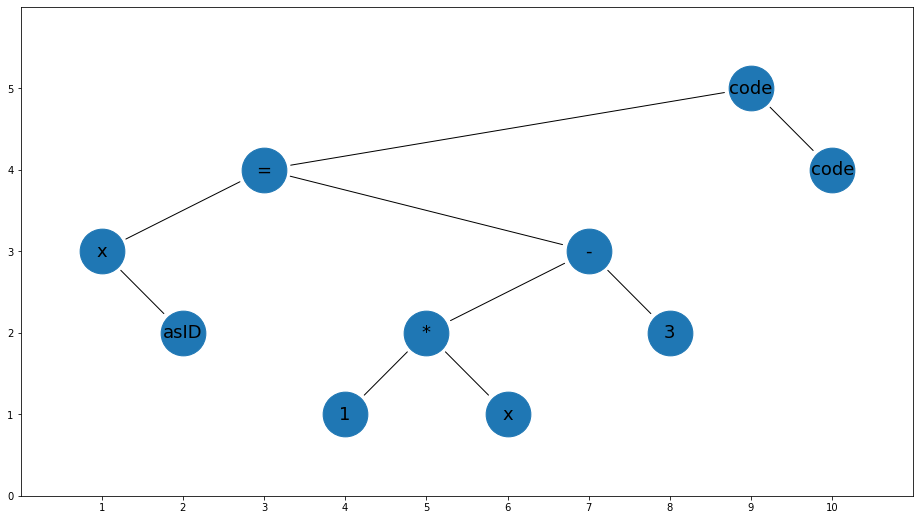

----------------------------------------------------------------------------------------------------
temp1 = 1 * x
temp2 = temp1 - 3
temp3 = x = temp2
----------------------------------------------------------------------------------------------------


Quadruples


[['assn'],
 ['temp1', '1', '*', 'x'],
 ['temp2', 'temp1', '-', '3'],
 ['temp3', 'x', '=', 'temp2']]

In [36]:
intermediate_code_generator("x = 1 * x - 3;",1,1)

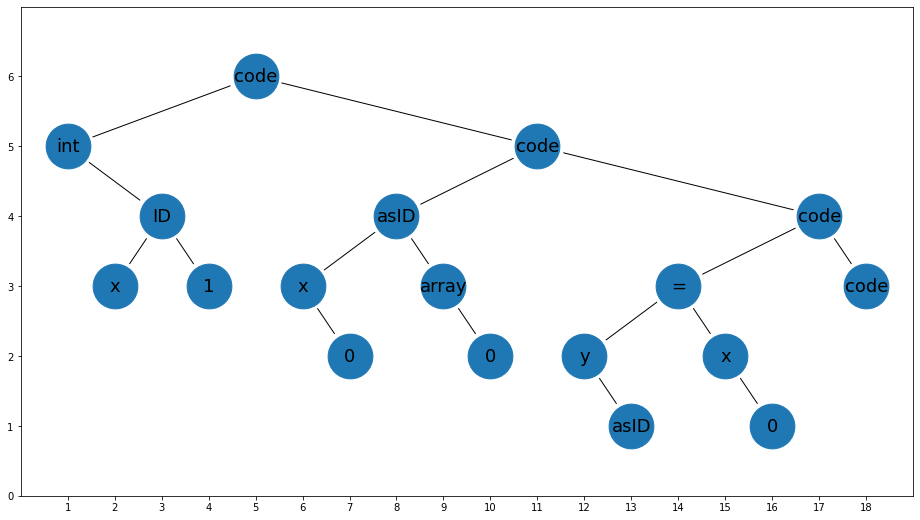

----------------------------------------------------------------------------------------------------
dec1 = x size:  1
temp2 = 0 = x
----------------------------------------------------------------------------------------------------


Quadruples


[['dec1', 'x', 1, None], ['assn'], ['assn'], ['temp2', '0', '=', 'x']]

In [37]:
intermediate_code_generator("""
int x[1];

x[0] = 0;

y = x[0];

""",1,1)

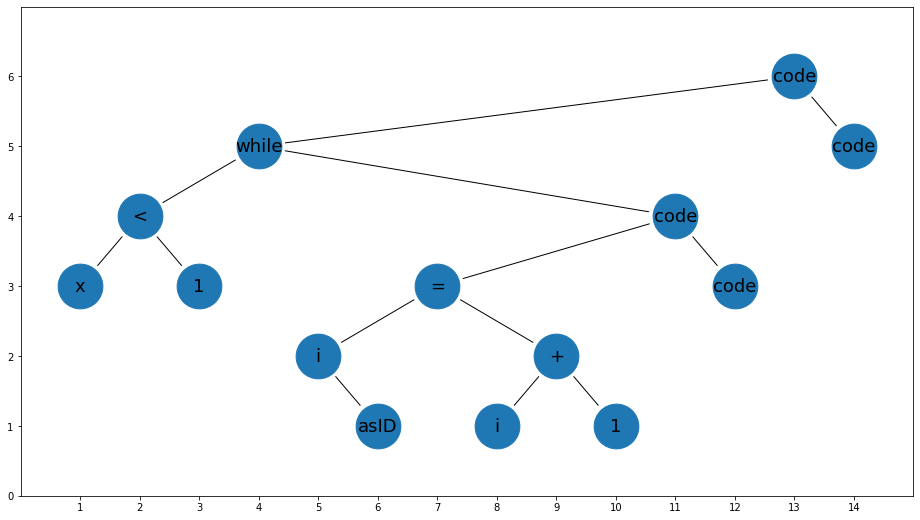

----------------------------------------------------------------------------------------------------
while1 :
if x >= 1 goto outw2
goto while1
temp3 = i + 1
temp4 = i = temp3
outw2 :
----------------------------------------------------------------------------------------------------


Quadruples


[['while', 'while1', 'outw2'],
 ['label', 'outw2', None, None],
 ['assn'],
 ['temp3', 'i', '+', '1'],
 ['temp4', 'i', '=', 'temp3']]

In [26]:
intermediate_code_generator("""while (x < 1){
                            i = i + 1;}""",1,1)

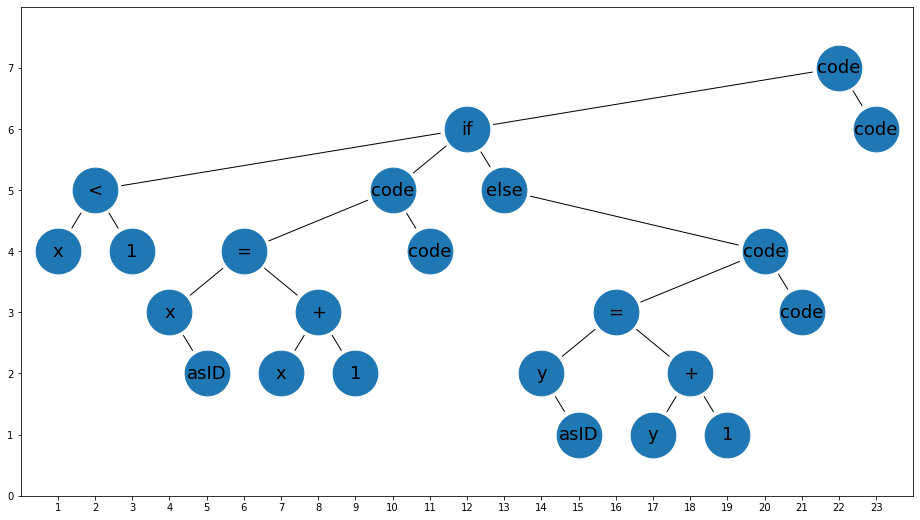

----------------------------------------------------------------------------------------------------
if1 :
if x >= 1 goto out_if
goto if1
temp2 = x + 1
temp3 = x = temp2
else4 :
temp5 = y + 1
temp6 = y = temp5
out_if :
----------------------------------------------------------------------------------------------------


Quadruples


[['if', 'if1', 'out_if'],
 ['label', 'out_if', None, None],
 ['assn'],
 ['temp2', 'x', '+', '1'],
 ['temp3', 'x', '=', 'temp2'],
 ['else', 'else4', 'out_else'],
 ['assn'],
 ['temp5', 'y', '+', '1'],
 ['temp6', 'y', '=', 'temp5']]

In [28]:
intermediate_code_generator("""if (x < 1){
x = x + 1;
}else{
y = y + 1;
}""",1,1)